In [1]:
# 불러오기
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
train =pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
# print(train.shape, test.shape) --> (10000, 15) (10000, 14)

In [2]:
import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras import metrics

import tensorflow_addons.metrics

C:\Users\SJ\anaconda3\envs\study\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\SJ\anaconda3\envs\study\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

<Axes: >

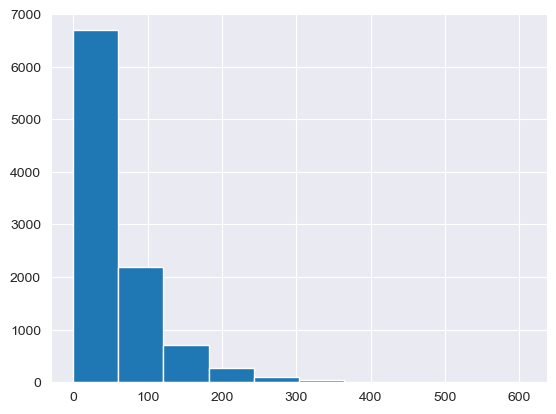

In [5]:
# EDA
train = train.drop("user_id", axis=1)
test_id = test.pop("user_id")
target = train.pop("target")
obj = train.select_dtypes("object").columns
# print(train.shape, test.shape) --> (10000, 13) (10000, 13)
# print(train.isnull().sum(), test.isnull().sum()) --> (10000, 13) (10000, 13)
# display(train.describe(), test.describe())
# display(train.describe(include="O"), test.describe(include="O"))
# preferred_difficulty_leve,  subscription_type --> label
# average_time_per_learning_session --> log
test['average_time_per_learning_session'].hist()

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              10000 non-null  int64  
 1   recent_login_time                  10000 non-null  int64  
 2   average_login_time                 10000 non-null  float64
 3   average_time_per_learning_session  10000 non-null  float64
 4   monthly_active_learning_days       10000 non-null  int64  
 5   total_completed_courses            10000 non-null  int64  
 6   recent_learning_achievement        10000 non-null  float64
 7   abandoned_learning_sessions        10000 non-null  int64  
 8   community_engagement_level         10000 non-null  int64  
 9   preferred_difficulty_level         10000 non-null  object 
 10  subscription_type                  10000 non-null  object 
 11  customer_inquiry_history           10000 non-null  int6

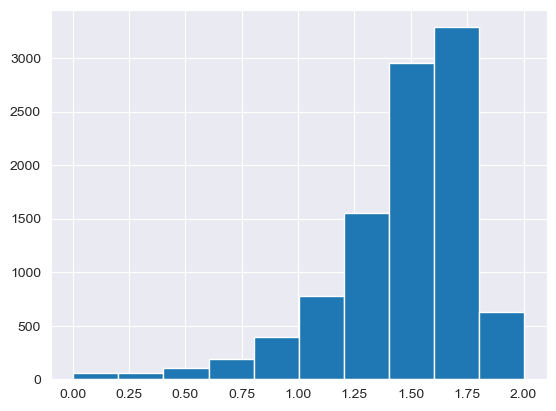

In [7]:
# 전처리
train['average_time_per_learning_session'] = np.log1p(train['average_time_per_learning_session'])
test['average_time_per_learning_session'] = np.log1p(test['average_time_per_learning_session'])
np.log1p(test['average_time_per_learning_session']).hist()

for o in obj:
    le = LabelEncoder()
    train[o] = le.fit_transform(train[o])
    test[o] = le.transform(test[o])

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              10000 non-null  int64  
 1   recent_login_time                  10000 non-null  int64  
 2   average_login_time                 10000 non-null  float64
 3   average_time_per_learning_session  10000 non-null  float64
 4   monthly_active_learning_days       10000 non-null  int64  
 5   total_completed_courses            10000 non-null  int64  
 6   recent_learning_achievement        10000 non-null  float64
 7   abandoned_learning_sessions        10000 non-null  int64  
 8   community_engagement_level         10000 non-null  int64  
 9   preferred_difficulty_level         10000 non-null  int32  
 10  subscription_type                  10000 non-null  int32  
 11  customer_inquiry_history           10000 non-null  int6

In [9]:
columns_to_scale = train.columns  # 실제 열 이름으로 대체해야 함

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 선택한 열을 Min-Max Scaling
train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
test[columns_to_scale] = scaler.fit_transform(test[columns_to_scale])

In [10]:
# 검증
x_tr, x_te, y_tr, y_te = train_test_split(train, target, test_size=0.2, random_state=1004)
# print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape) --> (8000, 13) (2000, 13) (8000,) (2000,)

In [11]:
import xgboost as xgb

# XGBoost 모델 생성 및 학습
model_xgb = xgb.XGBClassifier(random_state=1005, objective="binary:logistic")


param_grid = {
    'n_estimators': [200,250],
    'learning_rate': [None,0.2],
    'reg_lambda': [None,0.1]
    # 다른 매개변수들도 필요에 따라 추가할 수 있습니다.
}

In [218]:
# GridSearchCV를 사용하여 그리드 서치 수행
grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_tr, y_tr)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1005, ...),
             param_grid={'learning_rate': [None, 0.2],
                         'n_estimators': [200, 250],
                         'reg_lambda': [None, 0.1]},
             scoring='f1_macro')

In [220]:
scores_df = pd.DataFrame(grid_search.cv_results_)
scores_df[["params", "mean_test_score", "rank_test_score", "split0_test_score", "split1_test_score", "split2_test_score"]]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': None, 'n_estimators': 200, '...",0.508943,1,0.521694,0.503102,0.502032
1,"{'learning_rate': None, 'n_estimators': 200, '...",0.508879,2,0.507054,0.495904,0.502032
2,"{'learning_rate': None, 'n_estimators': 250, '...",0.508526,3,0.515538,0.500797,0.507667
3,"{'learning_rate': None, 'n_estimators': 250, '...",0.505604,5,0.504317,0.495885,0.491729
4,"{'learning_rate': 0.2, 'n_estimators': 200, 'r...",0.504147,7,0.505870,0.508172,0.499891
5,"{'learning_rate': 0.2, 'n_estimators': 200, 'r...",0.501507,8,0.513327,0.491585,0.498179
6,"{'learning_rate': 0.2, 'n_estimators': 250, 'r...",0.508150,4,0.501483,0.498332,0.506848
7,"{'learning_rate': 0.2, 'n_estimators': 250, 'r...",0.504617,6,0.511386,0.497751,0.502028


In [197]:
# 최적의 매개변수 출력
print("최적의 매개변수:", grid_search.best_params_)

최적의 매개변수: {'learning_rate': 0.2, 'n_estimators': 200, 'reg_lambda': 0.1}


In [198]:
# 최적의 모델에 대한 평가
best_model_xgb = grid_search.best_estimator_
y_pred_train_xgb = best_model_xgb.predict(x_te)
macro_f1_train_xgb = f1_score(y_te, y_pred_train_xgb, average='macro')
print(f'학습 세트 매크로 F1-score: {macro_f1_train_xgb:.4f}')

학습 세트 매크로 F1-score: 0.5007


In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# DecisionTreeClassifier 모델 생성
model_dt = DecisionTreeClassifier(random_state=1004)

param_grid = {
    'max_depth': [None],  # 결정 트리의 최대 깊이
    'min_samples_split': [2, 5, 10,15],  # 내부 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2],  # 리프 노드에 필요한 최소 샘플 수
    'max_features' : [None,4]
    # 다른 매개변수들도 필요에 따라 추가할 수 있습니다.
}

In [66]:
# GridSearchCV를 사용하여 최적의 매개변수 탐색
grid_search = GridSearchCV(model_dt, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1004),
             param_grid={'max_depth': [None], 'max_features': [None, 4],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10, 15]},
             scoring='f1_macro')

In [67]:
scores_df = pd.DataFrame(grid_search.cv_results_)
scores_df[["params", "mean_test_score", "rank_test_score", "split0_test_score", "split1_test_score", "split2_test_score"]]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': None, 'max_features': None, 'min...",0.520750,6,0.505947,0.539665,0.516946
1,"{'max_depth': None, 'max_features': None, 'min...",0.518608,9,0.498469,0.530260,0.523172
2,"{'max_depth': None, 'max_features': None, 'min...",0.526629,1,0.516416,0.535784,0.519937
3,"{'max_depth': None, 'max_features': None, 'min...",0.517334,10,0.508573,0.521655,0.511720
4,"{'max_depth': None, 'max_features': None, 'min...",0.519127,8,0.498158,0.528117,0.512749
5,"{'max_depth': None, 'max_features': None, 'min...",0.522872,5,0.514323,0.533854,0.519816
6,"{'max_depth': None, 'max_features': None, 'min...",0.524520,3,0.509638,0.530533,0.516949
7,"{'max_depth': None, 'max_features': None, 'min...",0.520589,7,0.510417,0.528672,0.518932
8,"{'max_depth': None, 'max_features': 4, 'min_sa...",0.504235,16,0.516171,0.496998,0.505372
9,"{'max_depth': None, 'max_features': 4, 'min_sa...",0.513928,12,0.515600,0.517468,0.525897


In [64]:
# 최적의 모델에 대한 평가
best_model_xgb = grid_search.best_estimator_
y_pred_train_xgb = best_model_xgb.predict(x_te)
macro_f1_train_xgb = f1_score(y_te, y_pred_train_xgb, average='macro')
print(f'학습 세트 매크로 F1-score: {macro_f1_train_xgb:.4f}')

학습 세트 매크로 F1-score: 0.5006


In [32]:


model3 = DecisionTreeClassifier(random_state=1004, min_samples_leaf=1, min_samples_split=10, max_features= 5)
model3.fit(x_tr, y_tr)
# pred = model3.predict(x_te)
# print(f1_score(y_te, pred, average='macro')) --> 0.5270466552850682

DecisionTreeClassifier(max_features=5, min_samples_split=10, random_state=1004)

In [33]:
y_pred_train = model3.predict(x_te)
macro_f1_train_catboost = f1_score(y_te, y_pred_train, average='macro',zero_division=0)
print(f'학습 세트 매크로 F1-score: {macro_f1_train_catboost:.4f}')

학습 세트 매크로 F1-score: 0.4948


In [187]:
y_pred_train = model1.predict(x_te)
macro_f1_train_catboost = f1_score(y_te, y_pred_train, average='macro', zero_division=0)
print(f'학습 세트 매크로 F1-score: {macro_f1_train_catboost:.4f}')

학습 세트 매크로 F1-score: 0.5110


In [82]:
from catboost import CatBoostClassifier


# CatBoost 모델 생성 및 학습
model_catboost = CatBoostClassifier()
# 탐색할 매개변수 그리드 정의
param_grid_catboost = {
    'iterations': [50, 100, 150],
    'depth': [ 5, 10],
    'learning_rate': [0.01,0.1],
    # 다른 매개변수들도 필요에 따라 추가할 수 있습니다.
}

In [83]:
# GridSearchCV를 사용하여 그리드 서치 수행
grid_search_catboost = GridSearchCV(model_catboost, param_grid_catboost, cv=5, scoring='f1_macro')
grid_search_catboost.fit(x_tr, y_tr)

0:	learn: 0.6923877	total: 1.4ms	remaining: 68.6ms
1:	learn: 0.6916106	total: 2.96ms	remaining: 71ms
2:	learn: 0.6908894	total: 4.19ms	remaining: 65.6ms
3:	learn: 0.6901762	total: 5.47ms	remaining: 62.9ms
4:	learn: 0.6894753	total: 6.67ms	remaining: 60.1ms
5:	learn: 0.6888216	total: 7.95ms	remaining: 58.3ms
6:	learn: 0.6881185	total: 9.18ms	remaining: 56.4ms
7:	learn: 0.6874472	total: 10.1ms	remaining: 53.2ms
8:	learn: 0.6867754	total: 11.3ms	remaining: 51.3ms
9:	learn: 0.6861057	total: 12.4ms	remaining: 49.6ms
10:	learn: 0.6854973	total: 13.6ms	remaining: 48.2ms
11:	learn: 0.6848557	total: 14.9ms	remaining: 47.2ms
12:	learn: 0.6842230	total: 16.1ms	remaining: 45.9ms
13:	learn: 0.6835828	total: 17.3ms	remaining: 44.6ms
14:	learn: 0.6829966	total: 18.6ms	remaining: 43.3ms
15:	learn: 0.6824059	total: 19.7ms	remaining: 42ms
16:	learn: 0.6818460	total: 21ms	remaining: 40.8ms
17:	learn: 0.6813093	total: 22.3ms	remaining: 39.6ms
18:	learn: 0.6806929	total: 23.5ms	remaining: 38.4ms
19:	learn:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000189336956D0>,
             param_grid={'depth': [5, 10], 'iterations': [50, 100, 150],
                         'learning_rate': [0.01, 0.1]},
             scoring='f1_macro')

In [84]:
scores_df = pd.DataFrame(grid_search_catboost.cv_results_)
scores_df[["params", "mean_test_score", "rank_test_score", "split0_test_score", "split1_test_score", "split2_test_score"]]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'depth': 5, 'iterations': 50, 'learning_rate'...",0.382096,6,0.382239,0.382239,0.382001
1,"{'depth': 5, 'iterations': 50, 'learning_rate'...",0.382001,12,0.382239,0.382239,0.381762
2,"{'depth': 5, 'iterations': 100, 'learning_rate...",0.382096,6,0.382239,0.382239,0.382001
3,"{'depth': 5, 'iterations': 100, 'learning_rate...",0.385942,5,0.386845,0.386845,0.382573
4,"{'depth': 5, 'iterations': 150, 'learning_rate...",0.382096,6,0.382239,0.382239,0.382001
5,"{'depth': 5, 'iterations': 150, 'learning_rate...",0.396507,4,0.393515,0.398746,0.399252
6,"{'depth': 10, 'iterations': 50, 'learning_rate...",0.382096,6,0.382239,0.382239,0.382001
7,"{'depth': 10, 'iterations': 50, 'learning_rate...",0.400705,3,0.395946,0.404234,0.397622
8,"{'depth': 10, 'iterations': 100, 'learning_rat...",0.382096,6,0.382239,0.382239,0.382001
9,"{'depth': 10, 'iterations': 100, 'learning_rat...",0.440021,2,0.430652,0.446987,0.449073


In [159]:
# 평가
pred = model3.predict(test)
result = pd.DataFrame({
    "user_id":test_id,
    "target":pred
})
result.to_csv("result.csv", index=False)
# pd.read_csv("result.csv")